In [76]:
import pandas as pd
import numpy as np
from scipy.stats import poisson 
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from fuzzywuzzy import process, fuzz
import time
import pickle

In [77]:
# downloading series script
dict_historical_data = pickle.load(open('dict_historical_data','rb'))
dict_matches_left = pickle.load(open('dict_matches_left','rb'))
dict_table = pickle.load(open('dict_table','rb'))

### Download Historical Data

In [78]:
# leagues_short = ['SP1', 'D1', 'E0', 'I1'] #spanish league, bundesliga, premier league, 
# dict_historical_data = {}

# for league in leagues_short:
#     frames = []
#     for i in range(15, 21):
#         df = pd.read_csv("http://www.football-data.co.uk/mmz4281/"+str(i)+str(i+1)+"/"+league+".csv")
#         df = df[['Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG']]
#         df = df.rename(columns={'FTHG': 'HomeGoals', 'FTAG': 'AwayGoals'})
#         df = df.assign(Season=i)
#         frames.append(df)
#     df_historical_data = pd.concat(frames)
#     df_historical_data['Date'] = pd.to_datetime(df_historical_data['Date'])
#     dict_historical_data[league] = df_historical_data

In [79]:
for i in dict_historical_data:
    dict_historical_data[i]['TotalGoals'] = dict_historical_data[i]['HomeGoals'] + dict_historical_data[i]['AwayGoals'] 

In [80]:
for i in dict_historical_data:
    print(i)
    print(dict_historical_data[i]['TotalGoals'].mean())

la_liga
2.689055574497102
premier_league
2.6886084583901773
bundesliga
2.9136980491942324
serie_a
2.678272742788872


In [81]:
#past 5 seasons
for i in dict_historical_data:
    dict_historical_data[i] = dict_historical_data[i].loc[dict_historical_data[i]['Season'] >= 15]

### Plot

/Applications/anaconda3/envs/scrapping/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


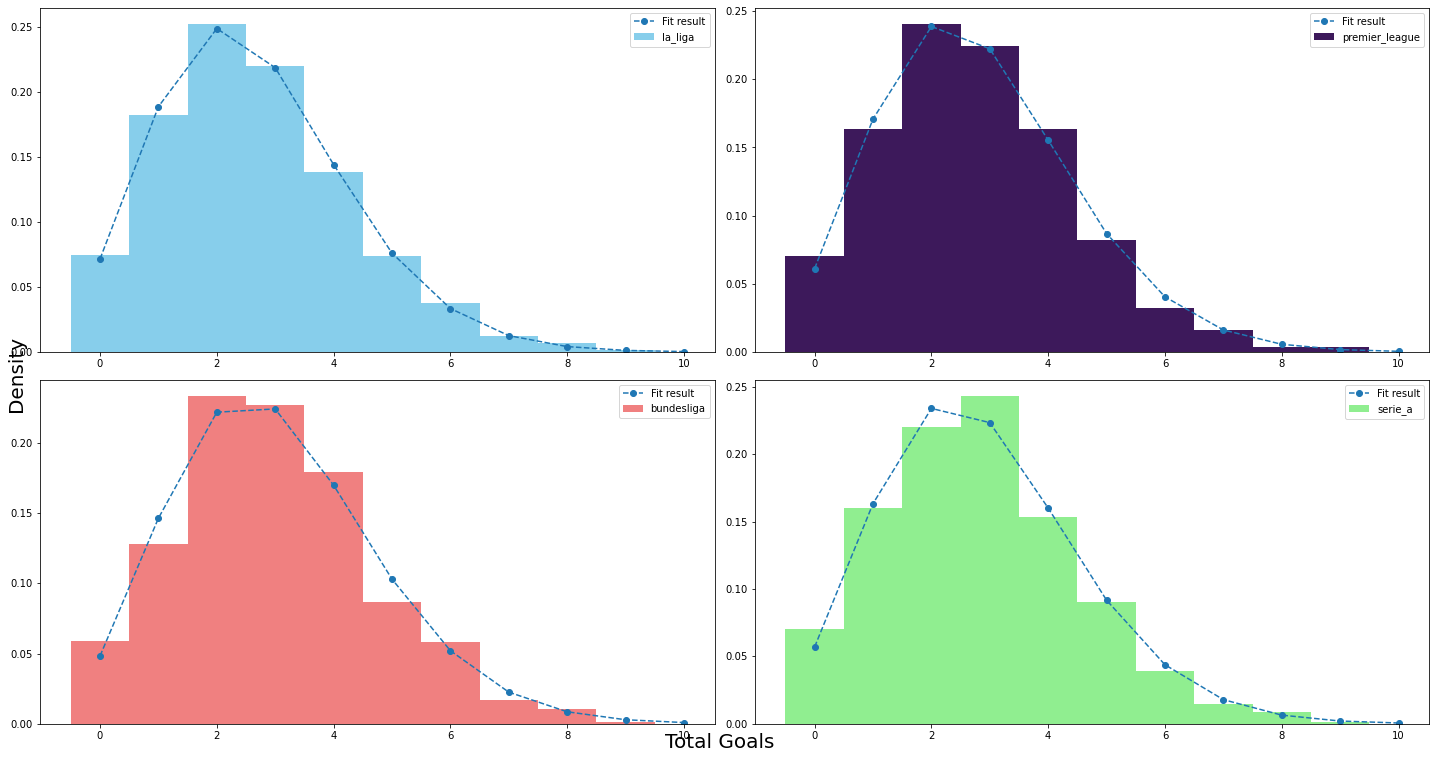

In [82]:
fig, ax = plt.subplots(nrows=2, ncols=2)
i=0
for row in ax:
    for col in row:
        dict_plot = {0:'la_liga', 1:'premier_league', 2:'bundesliga', 3:'serie_a'}
        dict_colors = {0:'skyblue', 1:'#3D195B', 2:'lightcoral', 3:'lightgreen'}
        data = dict_historical_data[dict_plot[i]]['TotalGoals']
        # the bins should be of integer width (poisson is an integer distribution)
        bins = np.arange(11) - 0.5
        entries, bin_edges, patches = col.hist(data, bins=bins, density=True, label=dict_plot[i], color=dict_colors[i])
        bin_middles = 0.5 * (bin_edges[1:] + bin_edges[:-1])

        #curve
        def fit_function(x, lamb):
            """Poisson function.Lamb is the fit parameter"""
            return poisson.pmf(x, lamb)
        parameters, cov_matrix = curve_fit(fit_function, bin_middles, entries) #optimal parameters
        x_plot = np.arange(0, 11)
        col.plot(x_plot, fit_function(x_plot, *parameters),marker='o', linestyle='--',
                 label='Fit result',)
        col.legend()
        i+=1

fig.set_size_inches(20, 10.5)
fig.text(0.5, 0.005, 'Total Goals', ha='center', size=20)
fig.text(0.005, 0.5, 'Density', va='center', rotation='vertical', size=20)
fig.tight_layout()
fig.show()
fig.savefig('histogram.png')

### Team Strength 

In [83]:
def calculate_strength(league):
    home = dict_historical_data[league][['HomeTeam', 'HomeGoals', 'AwayGoals']].rename(
        columns={'HomeTeam':'Team', 'HomeGoals':'HomeScored', 'AwayGoals':'HomeConceded'}).groupby(
        ['Team'], as_index=False)[['HomeScored', 'HomeConceded']].mean()
    away = dict_historical_data[league][['AwayTeam', 'HomeGoals', 'AwayGoals']].rename(
        columns={'AwayTeam':'Team', 'HomeGoals':'AwayConceded', 'AwayGoals':'AwayScored'}).groupby(
        ['Team'], as_index=False)[['AwayScored', 'AwayConceded']].mean()

    df_league_strength = pd.merge(home, away, on='Team')
    average_home_scored, average_home_conceded = home['HomeScored'].mean(), home['HomeConceded'].mean()
    average_away_scored, average_away_conceded = away['AwayScored'].mean(), away['AwayConceded'].mean()

    df_league_strength['HomeScored'] /= average_home_scored
    df_league_strength['HomeConceded'] /= average_home_conceded
    df_league_strength['AwayScored'] /= average_away_scored
    df_league_strength['AwayConceded'] /= average_away_conceded

    df_league_strength.set_index('Team', inplace=True)
    return df_league_strength

In [84]:
def predict_points(home, away):
    if home in df_league_strength.index and away in df_league_strength.index:
        #home_scored * away_conceded
        lamb_home = df_league_strength.at[home,'HomeScored'] * df_league_strength.at[away,'AwayConceded']
        lamb_away = df_league_strength.at[away,'AwayScored'] * df_league_strength.at[home,'HomeConceded']
        prob_home, prob_away, prob_draw = 0, 0, 0
        for x in range(0,11): #number of goals home team
            for y in range(0, 11): #number of goals away team
                p = poisson.pmf(x, lamb_home) * poisson.pmf(y, lamb_away)
                if x == y:
                    prob_draw += p
                elif x > y:
                    prob_home += p
                else:
                    prob_away += p
        
        points_home = 3 * prob_home + prob_draw
        points_away = 3 * prob_away + prob_draw
        return (points_home, points_away)
    else:
        return (0, 0)

In [85]:
#  Simulate the matches to predict final standings
league = 'la_liga' #'la_liga', 'premier_league', 'bundesliga', 'serie_a'
df_league_strength = calculate_strength(league)

list_points_home = []
list_points_away = []
for index, row in dict_matches_left[league].iterrows():
    home, away = row['HomeTeam'], row['AwayTeam']
    points_home, points_away = predict_points(home, away)
    dict_table[league].loc[dict_table[league]['Team'] == home, 'Points'] += points_home
    dict_table[league].loc[dict_table[league]['Team'] == away, 'Points'] += points_away
    #storing every match result
    list_points_home.append(round(points_home, 1))
    list_points_away.append(round(points_away, 1))
    
dict_table[league] = dict_table[league].sort_values('Points', ascending=False).reset_index()
dict_table[league] = dict_table[league][['Team', 'Points']]
dict_table[league].round(0)

,Team,Points
0,Ath Madrid,81.0
1,Real Madrid,78.0
2,Barcelona,76.0
3,Villarreal,61.0
4,Sevilla,60.0
5,Sociedad,58.0
6,Celta,50.0
7,Ath Bilbao,49.0
8,Valencia,47.0
9,Granada,46.0


In [86]:
#Run code 4 times with league =  #'la_liga', 'premier_league', 'bundesliga', 'serie_a' and then concat
# pd.concat([dict_table['premier_league'].round(0), dict_table['la_liga'].round(0), dict_table['bundesliga'].round(0),
#           dict_table['serie_a'].round(0)], axis=1)

In [87]:
# dict_matches_left['serie_a']['PointsHome'] = list_points_home
# dict_matches_left['serie_a']['PointsAway'] = list_points_away

# for i in pd.concat([dict_matches_left['premier_league'], dict_matches_left['la_liga'], dict_matches_left['bundesliga'],
#           dict_matches_left['serie_a']]).values:
#     print(i[0]+','+i[1]+','+str(i[2])+','+str(i[3]))